# Purpose of this notebook:
The purpose of this notebook is to document and demo various functions that can be utilized in order to generate a plot of activity or some other statistic onto an averaged subject's brain.

In this notebook we will cover the following topics:
1). Gathering subject's electrodes and rendering brain surface plots based upon the number of subjects with nearby electrodes
2). Plotting a single subject's subsequent memory effect onto an average surface brain

At the end of this you'll have created a file which can then be viewed using the various scripts locally (not on rhino)

### Relevant imports

In [19]:
from time import time
import numpy as np
from scipy.spatial.distance import euclidean
from os import path as op
from nibabel.freesurfer.io import read_geometry
from six import b
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix
import nibabel as nib
from itertools import product
import os, sys
import pickle
from ptsa.data.readers import TalReader, JsonIndexReader
from collections import OrderedDict
sys.path.append('/home2/loganf/SecondYear/CML_lib')
from GetDataNew import get_subjects

### Function to load an atlas of the subject

In [3]:
def get_subject_brainatlas(subject, experiment, return_channels=False):
    """Returns a subject's talairach using TalReader and JsonIndexReader
    -----
    INPUTS:
    -----
    subject: str, subject ID, e.g. 'R1111M'
    experiment: str, experiment, e.g. 'FR1', 'catFR1'
    return_channels: bool, default = False, whether to return arrays of
                     monopolar and bipolar channels used for EEGReader
    ------
    OUTPUTS if return_channels is False:
    ------
    tal_reader.read(): np.recarray, an array containing relevant values 
                       for electrode localization
    ------
    OUTPUTS if return_channels is True:
    ------                   
    mp: np.recarray, monopolar channels used for EEGReader
    bp: np.recarray, bipolar channels used for EEGReader
    tal_reader.read(): np.recarray, an array containing relevant values 
                       for electrode localization
    """
    
    # Check if we're using this locally or through rhino directly
    cwd = os.getcwd()
    local = '' if (cwd.split('/')[1][:4] == 'home') else '/Volumes/rhino'
    protocol = local + '/protocols/r1.json'
    
    if experiment == 'pyFR':
        path = os.path.join('/data/eeg/', subject, 'tal', subject + '_talLocs_database_bipol.mat')
        tal_reader = TalReader(filename=path)
        
        if return_channels:
            mp = tal_reader.get_monopolar_channels()
            bp = tal_reader.get_bipolar_pairs()
            return mp, bp, tal_reader.read()
        
        return tal_reader.read()
            
    # Load the protocol 
    jr = JsonIndexReader(protocol)
    
    # Get the path for the TalReader
    pairs_path = jr.get_value('pairs', subject=subject, experiment=experiment)
    
    # Create an instance of the TalReader object
    tal_reader = TalReader(filename=pairs_path)
    
    # If desired, also return the monopolar and bipolar channels
    if return_channels:
        mp = tal_reader.get_monopolar_channels()
        bp = tal_reader.get_bipolar_pairs()
        return mp, bp, tal_reader.read()
    
    # Otherwise just return the tal
    return tal_reader.read()

# Demo how to create an electrode density plot across all FR1 subjects

In [4]:
def get_avg_surface_spheres_ranges(radius=10, step=3):
    """ Generates a sphere centroid w/ radius radius in mm stepped every step in mm using average subject brain

    Parameters
    ------INPUTS------
    radius: int, by default 10, the radius in mm of the average surface spheres to generate
    step: int, by default 3, the step in mm of the average surface spheres to generate
    ------OUTPUTS-----
    x_range, y_range, z_range: np.array, range of valid values with discrete steps.
    """
    # Format path for local mounted vs local access
    basedir = '/data/eeg/freesurfer/subjects/'
    if not os.path.exists(basedir):
        basedir = os.path.join('/Volumes/rhino', basedir)

        # Get cortical surface of average patient right and left hemi
    rh = nib.freesurfer.read_geometry(os.path.join(basedir, 'average/surf/rh.pial'))
    lh = nib.freesurfer.read_geometry(os.path.join(basedir, 'average/surf/lh.pial'))
    surface = np.concatenate((lh[0], rh[0]))

    # Get minimum and maximum x value, use parameters to make range
    x_min, x_max = np.min(surface[:, 0]), np.max(surface[:, 0])
    x_range = np.arange(x_min + radius, x_max - radius, step)

    # Get minimum and maximum y value, use parameters to make range
    y_min, y_max = np.min(surface[:, 1]), np.max(surface[:, 1])
    y_range = np.arange(y_min + radius, y_max - radius, step)

    # Get minimum and maximum z value, use parameters to make range
    z_min, z_max = np.min(surface[:, 2]), np.max(surface[:, 2])
    z_range = np.arange(z_min + radius, z_max - radius, step)

    return x_range, y_range, z_range


def get_avg_surface_spheres(subject, experiment, radius=10, step=3, as_index=True):
    """Returns a dictionary where each key is str(x)_str(y)_str(z) in average subject space
    and values are corresponding bipolar channel names (['061', '062', etc.]) or their index
    within radius mm of the atlas brain

    Parameters
    ------INPUTS------
    subject: str, subject_id,
    radius: int, by default 10, the radius in mm of the average surface spheres to generate
    step: int, by default 3, the step in mm of the average surface spheres to generate
    as_index: bool, by default True, whether to return the indicies rather than the raw values for
              the bipolar_pairs that match
    ------OUTPUTS------
    subject_sphere_d: dictionary of matches
    """
    
    mp, bp, atlas = get_subject_brainatlas(subject, experiment, return_channels=True)
    # For loop only necessary for older versions of ptsa compatibility...
    # Otherwise direct indexing is obviously better and can be changed to that
    coords = np.concatenate([np.vstack((avg['atlases']['avg.dural']['x'], 
                                        avg['atlases']['avg.dural']['y'], 
                                        avg['atlases']['avg.dural']['z'])).T
                             for avg in atlas])

    # x,y,z boundries of avg brain stepped every step with a spherical radius of radius
    x_range, y_range, z_range = get_avg_surface_spheres_ranges(radius=radius, step=step)

    subject_sphere_d = {}  # Add data here

    # Use itertools to make essentially a nested for loop of them
    # E.g. as if we did for x in x_range: for y in y_range: for z in z_range:
    for sphere_center in product(x_range, y_range, z_range):

        # Find distance of each center to all coords
        dist = np.linalg.norm(coords - np.array(sphere_center), axis=1)

        # Find where it's closer than the defined radius
        matches = np.where(dist < radius)

        # If there are any matches add it to the dictionary
        if len(matches[0]) > 0:
            x, y, z = sphere_center
            # Format key as a union of x_y_x coordinates
            key = (str(x.round(2)) + '_' + str(y.round(2)) + '_' + str(z.round(2)))
            if as_index:
                subject_sphere_d[key] = matches
            else:
                subject_sphere_d[key] = bp[matches]

    return subject_sphere_d

### Get all FR1 subjects

In [66]:
print(help(get_subjects))
f_subjects = get_subjects(experiment='FR1')
print(len(f_subjects))

Help on function get_subjects in module GetDataNew:

get_subjects(experiment)
    Return an array of subjects who participanted in the given experiment
    
    PARAMETERS
    ------
    INPUTS:
    experiment: str, the kind of experiment to input, for RAM subjects use json reader field for json files and
                matlab folders for matlab files
    
                ###Accepted arguments###
                valid json experiments:
                    [u'FR1', u'FR2', u'FR3', u'FR5', u'FR6', u'PAL1', u'PAL2',
                     u'PAL3', u'PAL5', u'PS1', u'PS2', u'PS2.1', u'PS3', u'PS4_FR',
                     u'PS4_catFR', u'PS5_catFR', u'TH1', u'TH3', u'THR', u'THR1',
                     u'YC1', u'YC2', u'catFR1', u'catFR2', u'catFR3', u'catFR5', u'catFR6']
    
                valid matlab experiments:
                    ['RAM_CatFR1' 'RAM_CatFR2' 'RAM_CatFR3' 'RAM_DBS1' 'RAM_DBS2' 'RAM_FR1'
                     'RAM_FR1-restored' 'RAM_FR2' 'RAM_FR3' 'RAM_FR3_pilot' 'RAM_FR

### Make a dictionary with the number of subjects that have a bipolar pair within a given area

In [28]:
subject_density_dict = OrderedDict()
    
start_time = time()
# Go through each subject and see which centroids they have bipolar pairs in
for i, subject in enumerate(f_subjects):
    try:
        s = time()
        subject_sphere_dict = get_avg_surface_spheres(subject=subject, 
                                                      experiment='FR1', 
                                                      radius=10, 
                                                      step=3, 
                                                      as_index=True)
        # Go through each x_y_z point and add it to the subject dictionary
        for k,v in enumerate(subject_sphere_dict):
            if v not in subject_density_dict:
                subject_density_dict[v] = []
            if v in subject_density_dict:
                subject_density_dict[v].append(1)
        print('Total Time of {}: {}'.format(subject, time()-s))
        
    except Exception as e:
        print(e)
        print(subject)
        continue
print('Total Time all subjects: {}'.format(start_time-time()))  

Total Time of R1001P: 2.19023895264
Total Time of R1002P: 1.85484600067
Total Time of R1003P: 2.16330695152
Total Time of R1006P: 2.09743094444
Total Time of R1010J: 2.19923186302
Total Time of R1015J: 2.20999908447
Total Time of R1018P: 2.09105110168
Total Time of R1020J: 2.05608105659
Total Time of R1022J: 1.91049098969
Total Time of R1023J: 2.05374288559
Total Time of R1026D: 2.03185105324
Total Time of R1027J: 2.10671901703
Total Time of R1030J: 2.03660607338
Total Time of R1031M: 1.66036295891
Total Time of R1032D: 2.12924098969
Total Time of R1033D: 2.12403488159
Total Time of R1034D: 2.20876383781
Total Time of R1035M: 2.00627589226
Total Time of R1036M: 1.99292111397
Total Time of R1039M: 2.30075001717
Total Time of R1042M: 2.03156900406
Total Time of R1044J: 2.22338318825
Total Time of R1045E: 2.0809700489
Total Time of R1048E: 1.81783819199
Total Time of R1049J: 2.02835488319
Total Time of R1050M: 1.94265699387
Total Time of R1051J: 1.81959915161
Total Time of R1052E: 2.20301

# Code for label writing

In [62]:
import time

class Label(object):
    """Code Written by Jim Kregal&Logan Fickling for writing annotation labels to the surface of 
    an averaged subject brain"""

    def __init__(self, tal, pos=None, values=None, hemi=None, comment="",
                 name=None, outdir=None, subject=None, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=3.0,
                 stat=None, smooth=0.0, x=None, y=None, z=None):
        if hemi == 'lh':
            self.surf = basedir + 'average/surf/lh.pial'

        elif hemi == 'rh':
            self.surf = basedir + 'average/surf/rh.pial'

        if x is None:
            x = tal['atlases']['avg.dural']['x']

        if y is None:
            y = tal['atlases']['avg.dural']['y']

        if z is None:
            z = tal['atlases']['avg.dural']['z']

        pos = np.vstack((x, y, z)).T

        # need to filter all the electrodes by hemisphere
        if hemi == 'lh':
            stat = stat[pos[:, 0] < 0]
            pos = pos[pos[:, 0] < 0]
        elif hemi == 'rh':
            stat = stat[pos[:, 0] > 0]
            pos = pos[pos[:, 0] > 0]

        # TODO: may want to exclude depth electrodes
        # TODO: may want to have minimum distance to surface

        self.surface = nib.freesurfer.read_geometry(os.path.join(basedir, 'average' + '/surf/' + hemi + '.pial'))
        self.cortex = np.sort(
            nib.freesurfer.read_label(os.path.join(basedir, 'average' + '/label/' + hemi + '.cortex.label')))
        self.sulc = nib.freesurfer.read_morph_data(os.path.join(basedir, 'average' + '/surf/lh.sulc'))

        self.pos = pos
        self.stat = stat

        self.radius = radius
        self.hemi = hemi
        self.comment = comment
        self.verbose = verbose
        self.subject = subject
        self.name = name
        self.outdir = outdir
        self.smooth = smooth / 2.35482

    def map_stat_to_label(self):
        """Main function to call, writes a file that can then be read onto a brain surface"""
        self.coords, faces, vertices = self.get_vertices_from_surf()

        fnames = []
        elec_vertices = np.empty(self.pos.shape[0], dtype=int)

        filename = op.join(self.outdir, self.subject)
        path_head, name = op.split(filename)
        if name.endswith('.label'):
            name = name[:-6]
        if not (name.startswith(self.hemi) or name.endswith(self.hemi)):
            name += '-' + self.hemi
        filename = op.join(path_head, name) + '.label'

        start_time = time.time()

        self.counts = np.full(len(vertices), 0)
        self.vertices = vertices
        self.values = np.full(len(vertices), 0.)

        connectivity = mesh_dist(self.surface[1], self.surface[0])

        for i, elec_coord in enumerate(self.pos):
            elec_vertices[i] = self.get_nearest_vertex(elec_coord)[0]

        elec_dists = sparse.csgraph.dijkstra(connectivity, indices=elec_vertices)

        for i, e_dist in enumerate(elec_dists):
            self.values[np.where(((e_dist < self.radius) & (e_dist > 0.0)) | (vertices == elec_vertices[i]))] += \
            self.stat[i]
            self.counts[np.where(((e_dist < self.radius) & (e_dist > 0.0)) | (vertices == elec_vertices[i]))] += 1

        self.values = self.values / self.counts
        # TODO: may want to remove vertices, pos, values where there is no data to make a smaller label files
        label = write_label(filename, self)
        fnames.append(filename)

        return fnames

    def get_vertices_from_surf(self):
        '''

        :param hemi:
        :return:
        '''

        coords, faces = read_geometry(self.surf)
        vertices = np.arange(coords.shape[0])
        return coords, faces, vertices

    def get_nearest_vertex(self, elec_coord):
        '''

        :return:
        '''

        dist = np.linalg.norm(self.coords - elec_coord, axis=1)
        idx = np.where(dist == dist.min())[0]

        return idx


def write_label(filename, label, verbose=None):
    """Write a FreeSurfer label.
    Parameters
    ----------
    filename : string
        Path to label file to produce.
    label : Label
        The label object to save.
    verbose : bool, str, int, or None
        If not None, override default verbose level (see :func:`mne.verbose`
        and :ref:`Logging documentation <tut_logging>` for more).
    Notes
    -----
    Note that due to file specification limitations, the Label's subject and
    color attributes are not saved to disk.
    See Also
    --------
    write_labels_to_annot
    """

    with open(filename, 'wb') as fid:
        n_vertices = len(label.vertices)
        data = np.zeros((n_vertices, 5), dtype=np.float)
        data[:, 0] = label.vertices
        data[:, 1:4] = label.coords  # self.pos #1e3 *
        data[:, 4] = label.values
        fid.write(b("#%s\n" % label.comment))
        fid.write(b("%d\n" % n_vertices))
        for d in data:
            fid.write(b("%d %f %f %f %f\n" % tuple(d)))
    return label


def average_duplicates(vertices, pos, values):
    result_vertices = np.unique(vertices)
    result_values = np.empty(result_vertices.shape)
    result_pos = np.empty((1, len(result_vertices), 3))

    for i, vertex in enumerate(result_vertices):
        result_values[i] = np.mean(values[vertices == vertex])
        result_pos[0, i, :] = np.mean(pos[0, vertices == vertex, :], axis=0)

    return result_vertices, result_pos, result_values


def gaussian(dist, sig):
    return np.exp(-np.power(dist, 2.) / (2 * np.power(sig, 2.)))


def mesh_edges(tris):
    """Return sparse matrix with edges as an adjacency matrix.
    Parameters
    ----------
    tris : array of shape [n_triangles x 3]
        The triangles.
    Returns
    -------
    edges : sparse matrix
        The adjacency matrix.
    """
    if np.max(tris) > len(np.unique(tris)):
        raise ValueError('Cannot compute connectivity on a selection of '
                         'triangles.')

    npoints = np.max(tris) + 1
    ones_ntris = np.ones(3 * len(tris))

    a, b, c = tris.T
    x = np.concatenate((a, b, c))
    y = np.concatenate((b, c, a))
    edges = coo_matrix((ones_ntris, (x, y)), shape=(npoints, npoints))
    edges = edges.tocsr()
    edges = edges + edges.T
    return edges


def mesh_dist(tris, vert):
    """Compute adjacency matrix weighted by distances.
    It generates an adjacency matrix where the entries are the distances
    between neighboring vertices.
    Parameters
    ----------
    tris : array (n_tris x 3)
        Mesh triangulation
    vert : array (n_vert x 3)
        Vertex locations
    Returns
    -------
    dist_matrix : scipy.sparse.csr_matrix
        Sparse matrix with distances between adjacent vertices
    """
    edges = mesh_edges(tris).tocoo()

    # Euclidean distances between neighboring vertices
    dist = np.linalg.norm(vert[edges.row, :] - vert[edges.col, :], axis=1)
    dist_matrix = csr_matrix((dist, (edges.row, edges.col)), shape=edges.shape)
    return dist_matrix

### Prepare the data for the object used to create brain plots

In [56]:
my_label_d = OrderedDict()
for k,v in enumerate(subject_density_dict):
    my_label_d[v] = sum(subject_density_dict[v])

In [57]:
def split_keys_to_xyz_coords(dictionary):
    """Return arrays of x y and z coordinates from a dictionary withs keys set up like 'x_y_z' 
    dictionary: dict, dictionary with keys being xyz coords and values being stats
    returns
    x, y, z: np.array, arrays of x y or z values
    """
    x = map(lambda s:float(s.split('_')[0]), dictionary.keys())
    y = map(lambda s:float(s.split('_')[1]), dictionary.keys())
    z = map(lambda s:float(s.split('_')[2]), dictionary.keys())
    return np.array(x), np.array(y), np.array(z)

In [58]:
X, Y, Z = split_keys_to_xyz_coords(my_label_d)
stats = np.array(my_label_d.values())
atlas = get_subject_brainatlas('R1111M', 'FR1', return_channels=False)
label_name = 'all_fr1_electrodes' # What we want to call the file
label_dir = '/scratch/loganf/' # where we want to save


# Generate plots for left hemisphere

In [64]:
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='lh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=stats, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)

/home2/loganf/anaconda3/envs/ptsa_fresh/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in divide


2572.12319613


# Generate plots for Right hemisphere

In [65]:
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='rh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=stats, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)

/home2/loganf/anaconda3/envs/ptsa_fresh/lib/python2.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in divide


2437.83229995


# Subsequent memory effect processing:
Install: ptsa, scipy, bottleneck, (if sys.path.append to my (Logan) home dir fails then possibly CML_lib, but I think I set it to readable.

In [113]:
from SpectralAnalysis.MentalChronometry import Subject
fr_subject = Subject(subject=f_subjects[0], experiment='FR1', session=0, 
                     eeg_start=0., eeg_end=1.6, eeg_buffer=1.0, 
                     verbose=True, save=False)

Set Attribute possible_sessions


In [114]:
fr_subject.set_events()
events=fr_subject.events[fr_subject.events['type']=='WORD']

Setting all events....
Mean Recall in session: 17.6666666667%


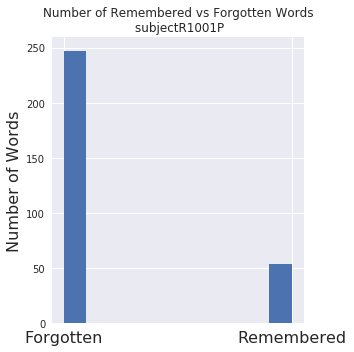

In [280]:
import pandas as pd
from matplotlib import pyplot as plt
% matplotlib inline
fig, ax = plt.subplots(figsize=(5,5))
df = pd.DataFrame(events.recalled)
df.hist(ax=ax)
plt.title('Number of Remembered vs Forgotten Words\n subject{}'.format(fr_subject.subject))

x = np.arange(2)
label = ['Forgotten', 'Remembered']
xticks = plt.xticks(x, label, rotation='horizontal', fontsize=16)
ax.set_ylabel('Number of Words', fontsize = 16)
plt.tight_layout()

In [145]:
fr_subject.set_eeg(events=events, remove_artifacts=True)

Setting Json mp, bp, and tal
Setting Logan brain atlas to tal
Setting eeg for passed events....
Setting attribute bad_channels
Removing [58.0, 62.0] linenoise....
Not removing frequency < .1Hz....
Converting monopolar channels to bipolar pairs....


In [146]:
fr_subject.morlet(data = fr_subject.eeg, output='power')

Starting Morlet Wavelet....
(72, 300, 13)
('CPP total time wavelet loop: ', 17.32143807411194)
Starting Log transform....
Removing the buffer


In [147]:
# Average into bands
timeseries = fr_subject.power
freq_names = map(lambda x:'theta' if x else 'hfa', 
                 timeseries.frequency < 8.06)
timeseries['frequency'] = freq_names
timeseries = timeseries.groupby('frequency').mean('frequency')

In [166]:
from scipy.stats import zscore
# Zscore
timeseries = timeseries.transpose('events', 'frequency','bipolar_pairs','time')
z_data = zscore(timeseries,axis=0)
timeseries.data = z_data
remembered_evs = timeseries.events.data['recalled']==1
remembered = timeseries.sel(events = remembered_evs)
forgotten = timeseries.sel(events = ~remembered_evs)
forgotten = forgotten.mean('time')
remembered = remembered.mean('time')

Since there are more forgotten words than remembered words we'll shuffle the forgotten words 10000 times and average the t-stat from each of these shuffles.

In [228]:
from scipy.stats import ttest_ind 
from time import time 
tstats = []
pvals = []

s = time()
for i in np.arange(10000):
    num_rem = len(remembered['events'])
    num_for = len(forgotten['events'])
    select = np.random.choice(np.arange(num_for), replace=False, size=num_rem)
    t, p = ttest_ind(remembered, forgotten[select], 0)
    tstats.append(t)
    pvals.append(p)
tstat_arr = np.array(tstats).mean(0)
print(time()-s)

13.3809459209


In [242]:
ts_tstat = timeseries.mean('events').mean('time')
ts_tstat.data = tstat_arr
hfa = ts_tstat[0]
theta = ts_tstat[1]

In [257]:
atlas = get_subject_brainatlas(fr_subject.subject, 'FR1')

# For loop only necessary for older versions of ptsa compatibility...
# Otherwise direct indexing is obviously better and can be changed to that
coords = np.concatenate([np.vstack((avg['atlases']['avg.dural']['x'], 
                                    avg['atlases']['avg.dural']['y'], 
                                    avg['atlases']['avg.dural']['z'])).T
                         for avg in atlas])
X, Y, Z = coords[:,0], coords[:,1], coords[:,2]

# Make Theta

In [278]:
import time
label_name = 'R1001P_theta' # What we want to call the file
label_dir = '/scratch/loganf/' # where we want to save
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='rh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=theta.data, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='lh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=theta.data, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)

4.65221309662
4.35722303391


# Make HFA:
For each electrode plot a radius of 10 with it's tstat value 

In [279]:
label_name = 'R1001P_hfa' # What we want to call the file
label_dir = '/scratch/loganf/' # where we want to save
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='rh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=hfa.data, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)
s = time.time()
my_label = Label(tal=atlas, pos=None, values=None, hemi='lh', comment="",
                 name=None, outdir=label_dir, subject=label_name, verbose=None,
                 basedir='/data/eeg/freesurfer/subjects/', radius=10.,
                 stat=hfa.data, smooth=3.0, x=X, y=Y, z=Z)
my_label.map_stat_to_label()
print(time.time()-s)

4.83900308609
4.3748819828
